# [Snow monitoring with Landsat](https://docs.dea.ga.gov.au/notebooks/05_Temporal_analysis/SnowMonitoringUsingLandsat.html)

## What does this notebook do?

This notebook gets the Landsat 8 data that has 6 spectral bands including visible (red,green,blue) and invisible (nir, swir1, swir2) bands. These bands are plotted individually and combined. Also, the NDVI and NDWI are calculated and plotted from these bands.

Since the production GSKY server can only return three bands at a time, two separate calls to GSKY are made to get all six bands.

###### Specifics

- Converting a DEA notebook example to use GSKY instead of datacube.

- Uses WCS to get an area from a specified layer/date/bbox/time, and differs from the DEA example.

- Only one time slice can be used in WCS. 
    - You can choose from all available times in the layer.

- If you can determine a valid BBox for a date (Tip: Use TerriaMap) it can be manually typed in.

- The DEA example, using datacube, can get the data for a time range. It is not possible in GSKY.

**Author:** Arapaut V. Sivaprasad

**Date:** 25 October, 2019

In [1]:
##########################################################
# Author: Arapaut V. Sivaprasad.                         #
# Dates: Created: 22/10/2019; Last Modified: 25/10/2019  #
##########################################################

from owslib.wcs import WebCoverageService
from random import randrange
import os
import xarray as xr
%matplotlib inline

### The WCS service on the GSKY server

The GSKY server is publicly available and runs on one of NCI's HPC nodes. To get the data a regular HTTPS call is made with the required parameters as a GET command.

The WCS (Web Coverage Service) is a very efficient way to get data spread across several hundred to thousands of files and directories. By specifying an area, date and data layer name the WCS service retrieves all the required data and combines it into a single NetCDF (or GeoTIFF) output. In this example we will use the NetCDF format to get the data and then plol it and/or analyse the data to pick up other features.

In [2]:
# Specify the GSKY production URL here. The layer is hard coded
gsky_url = 'https://gsky.nci.org.au/ows/dea'
wcs = WebCoverageService(gsky_url, version='1.0.0')
layer = "landsat8_nbar_16day"

# Uncomment below to see all layers.

#for layer in list(wcs.contents):
#    print ("Layer Name:", layer)
#    print ("Title:", wcs[layer].title, '\n')

### Get a time stamp

The data is stored as separate files with a time stamp, or time position, in each. This time stamp correspond to the data acqusition date and is used to retrieve the data for a particular area. Only one time stamp can be specified in one WCS query.

In [3]:
# To display the available time slices in any range, specify the start and end values as m,n below
time = wcs[layer].timepositions
n_times = len(time)
m = 0
n = n_times-1
#print ("Total of", n_times,'timepositions:\n\n', time[m:n])

# Unlike in the case of datacube, where a time range can be specified, GSKY requires a specific date.
# This specific time slice is specified below. 
t = n-3
wcs[layer].timepositions[t]

'2019-11-02T00:00:00.000Z'

### Specify a bounding box

To specify an area to analyse, you must give its bounding box coordinates (in EPSG:4326). This can be done either by hard coding it as e.g. *BBoxes[0] = ['148.62,-35.14,149.32,-36.58']* or by giving a tile ID(s) to calculate the BBox. Only one BBox can be specified in a WCS query.

The tiles are approximately 1x1 degree areas the Australian continent is divided into. A list of these tiles and their bounding boxes can be seen by uncommenting its code below. For instance, tiles '15_-40' and '15_-41' together cover all of ACT plus some of the surroundings. Sydney is covered by '17_-39'. 

Click [here](http://cmi.ga.gov.au/sites/default/files/2017-12/DEA%20Tiles_1.pdf) to view the tile map.


In [4]:
tiles_list = {}
with open("tiles_bboxes.txt") as f:
    for line in f:
        (key, val) = line.split()
        tiles_list[str(key)] = val

# Uncomment below to see all tiles and ther BBoxes
#tiles_list

#### Select a tile(s)

Give a tile ID to select an area. To specify an area larger than one tile you can give the top left corner and the bottom right corner tiles. A bounding box covering the entire area will be calculated. Please be aware that too large an area will cause a timeout error at the GSKY server.

In [5]:
# Give one tile or two tiles as [top left corner, bottom right corner] below.
#tiles = ['17_-39']  # Sydney
tiles = ['15_-40','15_-41']  # ACT
bbox = [tiles_list[tiles[0]],tiles_list[tiles[1]]]

# If you know a BBox containing data (Tip: use TerriaMap to find out) then type it in below.
#bbox = ['150.52,-34.15,151.34,-33.56'] # Sydney
bbox

['148.50,-34.71,149.73,-35.72', '148.64,-35.60,149.89,-36.61']

### Calculate the bounding box and adjust it to fit the plotting area

The plotting area has a default dimension of 337x240 pixels. When the area of the bounding box is different to this, the image will be adjusted to fit in this plot. It can result in distortion of the image. To avoid it, we re-calculate the bounding box below.

In [6]:
x = float(bbox[0][0:6])
y = float(bbox[0][7:13])
X = float(bbox[1][14:20])
Y = float(bbox[1][21:27])

# The longitude dimension is adjusted to fit the plot size of 337*220 pixels. 
# It is required to avoid distorting the image
X = float('%.2f'%(x + ((abs(Y - y) / 220) * 337)))
bbox = (x,y,X,Y)
bbox

(148.5, -34.71, 151.41, -36.61)

### Get the data from GSKY server using the WCS service

The call below asks for the True Color bands (red, green, blue). GSKY always labels the bands as Band1,2 and 3, and not as red, green, blue. If we need the False Color bands, a separate call has to be made. The returned data will still have the bands as Band1, 2, 3.

In [7]:
# Construct a WCS call to GSKY and send it.
output = wcs.getCoverage(identifier=layer, Styles='tc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)
print(output.geturl())

http://gsky.nci.org.au/ows/dea?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=148.5%2C-34.71%2C151.41%2C-36.61&time=2019-11-02T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=tc


#### Write the returned data into a file

The WCS service returns the data in NetCDF format and is written to a \*.nc file.

In [8]:
# Get the output data from GSKY and write it in a *.nc file
rand = str(randrange(1000))
ncfile_tc = './output/gsky_wcs_tc' + rand + '.nc'
with open(ncfile_tc, 'wb') as f:
    f.write(output.read())

### Get the False Color bands

To calculate other indices like snow, water and vegetation we need the False Color bands (e.g. nir, swir) as well as true color bands. A call to get the false color bands is sent in the cell below. Three bands 'nir', 'swir1' and 'swir2' will be returned.

In [9]:
# Construct a WCS call to GSKY and send it.
output = wcs.getCoverage(identifier=layer, Styles='fc',
                         time=[wcs[layer].timepositions[t]],
                         bbox=bbox,format='NetCDF',
                         crs='EPSG:4326', width=256, height=256)
print(output.geturl())

http://gsky.nci.org.au/ows/dea?version=1.0.0&request=GetCoverage&service=WCS&Coverage=landsat8_nbar_16day&BBox=148.5%2C-34.71%2C151.41%2C-36.61&time=2019-11-02T00%3A00%3A00.000Z&crs=EPSG%3A4326&format=NetCDF&width=256&height=256&Styles=fc


#### Write the returned data into a file

The WCS service returns the data in NetCDF format and is written to a \*.nc file.

In [10]:
# Get the output data from GSKY and write it in a *.nc file
rand = str(randrange(1000))
ncfile_fc = './output/gsky_wcs_fc' + rand + '.nc'
with open(ncfile_fc, 'wb') as f:
    f.write(output.read())

### Convert the NetCDF into an Xarray

To plot the data and to do other calculations we need to convert the NetCDF data int an Xarray. We have the true color and false color data in two files. Read these files, convert the data and save in two separate variables. Later we can get the bands by referring to Band1 to Band3 from both.

In [11]:
# Read the NetCDF file and convert it into an xarray dataset
ds_tc = xr.open_dataset(ncfile_tc)
ds_fc = xr.open_dataset(ncfile_fc)
ds = ds_tc

# Delete the created NetCDF files
try:
    os.remove(ncfile_tc)
    os.remove(ncfile_fc)
except OSError:
    pass

#### Plot the data

The plots below will display, singly or together, the true color and false color data.

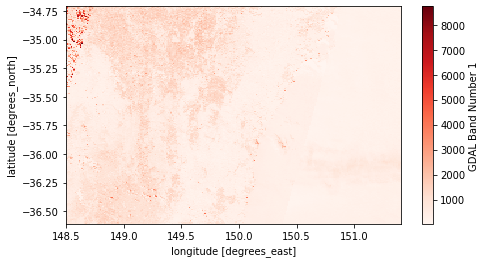

In [12]:
# Plot the red band from true color
ds_tc.Band1.plot(figsize=(7.51, 4.00), cmap = 'Reds');  

# This works too: 
#ds_tc['Band1'].plot(figsize=(7.51, 4.00), cmap = 'Reds')

# Display the raw data
#ds_tc
#ds_fc

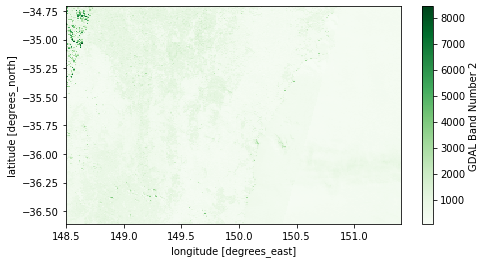

In [13]:
# Plot the green band from true color
ds_tc.Band2.plot(figsize=(7.51, 4.00), cmap = 'Greens');  

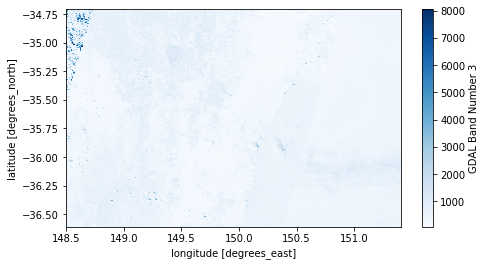

In [14]:
# Plot the blue band  from true color
ds_tc.Band3.plot(figsize=(7.51, 4.00), cmap = 'Blues');  

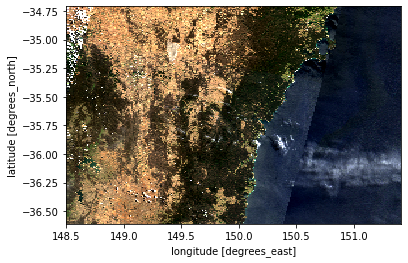

In [15]:
# Plot all three true color bands together
ds_tc[['Band1', 'Band2', 'Band3']].to_array().plot.imshow(robust=True)


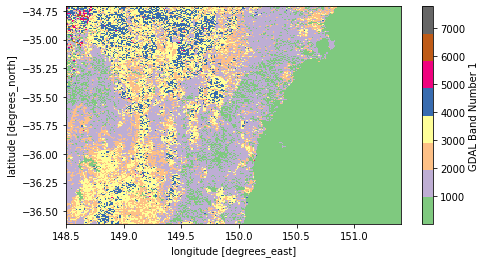

In [16]:
# Plot the nir
ds_fc.Band1.plot(figsize=(7.51, 4.00), cmap = 'Accent');  

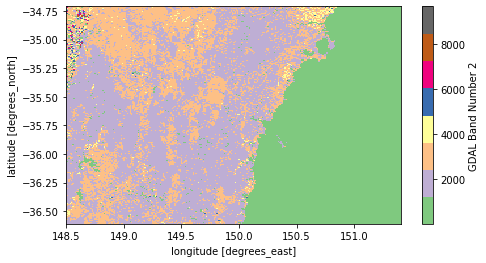

In [17]:
# Plot the swir1
ds_fc.Band2.plot(figsize=(7.51, 4.00), cmap = 'Accent');  

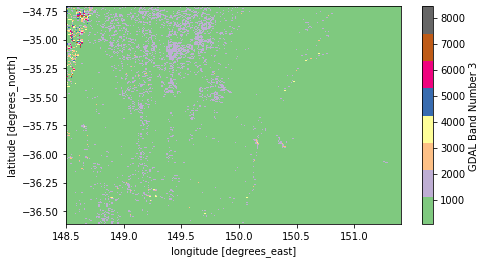

In [18]:
# Plot the swir2
ds_fc.Band3.plot(figsize=(7.51, 4.00), cmap = 'Accent');  

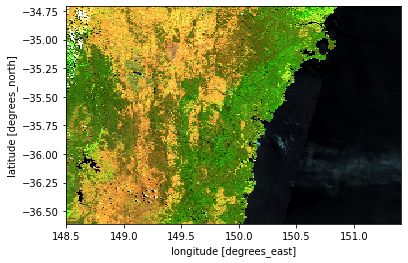

In [19]:
# Plot all three false color bands together
ds_fc[['Band1', 'Band2', 'Band3']].to_array().plot.imshow(robust=True)


### Compute Normalised Difference Water Index (NDWI)

The NDWI index is most appropriate for water body mapping. The water body has strong absorbability and low radiation in the range from visible to infrared wavelengths. The index uses the green and Near Infra-red bands of remote sensing images based on this phenomenon.

In [20]:
# Compute NDWI using the formula (green - nir) / (green + nir). This will calculate 
# NDWI for every time-step in the dataset:
ds_ndwi = (ds_tc.Band2 - ds_fc.Band1) / (ds_tc.Band2 + ds_fc.Band1)

# Uncomment below to see the data
#ds_ndwi

In [21]:
# We can now add this back into our dataset as a new data variable:
ds["NDWI"] = ds_ndwi

# Uncomment below to see the data
#ds


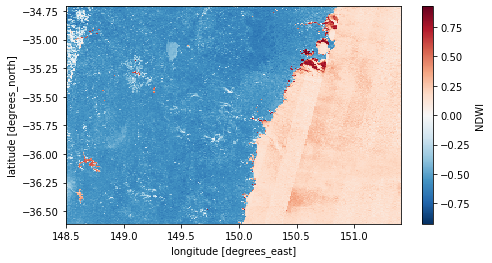

In [22]:
# First, we select the variable we want ('NDWI'), and then make a plot
ds.NDWI.plot(figsize=(7.51, 4.00));


### Compute Normalised Difference Vegetation Index (NDVI)¶

The normalized difference vegetation index (NDVI) is a simple graphical indicator that can be used to analyze remote sensing measurements and assess whether the target contains live green vegetation or not.

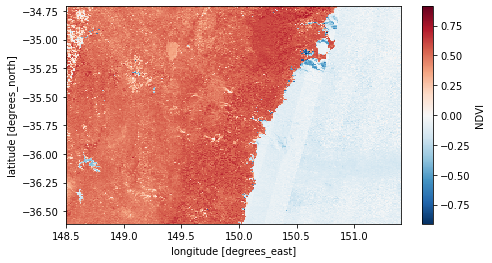

In [23]:
# Compute NDVI using the formula (nir - red) / (nir + red)
ds_ndvi = (ds_fc.Band1 - ds_tc.Band1) / (ds_fc.Band1 + ds_tc.Band1)

# Add this back into our dataset as a new data variable:
ds["NDVI"] = ds_ndvi

# Plot:
ds.NDVI.plot(figsize=(7.51, 4.00));

### Compute Normalised Difference Snow Index (NDSI)

Normalized Difference Snow Index (NDSI) is used to delineate the presence of snow/ice. It is a standardized ratio of the difference in the reflectance in the bands that take advantage of unique signature and the spectral difference to indicate snow from the surrounding features and even clouds.

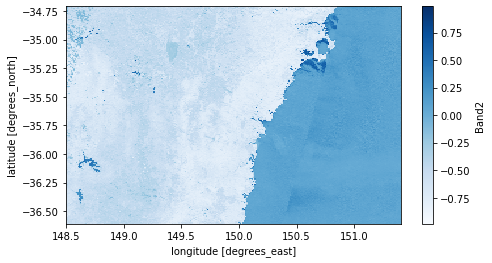

In [24]:
# Compute index by subtracting, summing and dividing the `green` and `swir1` bands
ds_ndsi = (ds_tc.Band2 - ds_fc.Band2) / (ds_tc.Band2 + ds_fc.Band2)

# Plot one sample timestep from the NDSI dataset
ds_ndsi.isel().plot(cmap='Blues', figsize=(7.51, 4.00))

### Threshold NDSI and NDVI to identify snowy, non-vegetated pixels



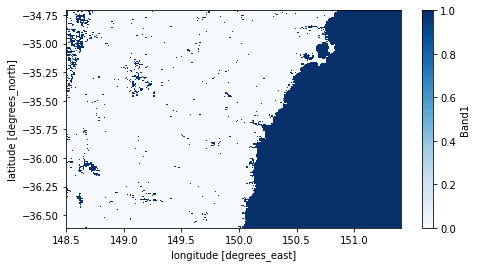

In [25]:
# Threshold that will be applied to the NDSI layer to identify pixels containing snow
ndsi_threshold = 0

# Threshold that will be applied to the NDVI layer to identify pixels containg vegetation
ndvi_threshold = 0.3

# Apply NDSI threshold defined above to identify snow (pixels with NDSI values greater than X)
snow_ds = ds_ndsi > ndsi_threshold

# Apply NDSI threshold defined above to identify snow (pixels with NDVI values less than X)
noveg_ds = ds_ndvi < ndvi_threshold

# Finally, keep only pixels that are both snowy AND non-vegetated:
snow_ds = noveg_ds & noveg_ds

# Plot the resulting layer
snow_ds.isel().plot(cmap='Blues', figsize=(7.51, 4.00))

#### Acknowledgements

This notebook page is derived from this [DEA notebook](https://docs.dea.ga.gov.au/notebooks/05_Temporal_analysis/SnowMonitoringUsingLandsat.html) and extensively changed to use GSKY server. All data comes from the GSKY server using the WCS service. Some, but not all, of the text used here are directly copied from the DEA page.